In [1]:
import numpy as np
from scipy import optimize
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [2]:
def cdf_x(x, lam=1):
    return np.maximum(1.-np.exp(-x*lam), 0)

def cdf_y(y, lam=1):
    return np.minimum(np.exp(y*lam), 1)

def w_copula(a, b, **kwargs):
    return np.maximum(a + b - 1, 0)

def m_copula(a, b, **kwargs):
    return np.minimum(a, b)

def prod_copula(a, b, **kwargs):
    return a*b

In [3]:
def eps_a(r_s, r_c, lam_x=1, snr_bob=1):
    lam_x_tilde = lam_x/snr_bob
    return cdf_x(2**(r_s+r_c)-1, lam=lam_x_tilde)

def eps_b(r_s, r_c, lam_y=1, snr_eve=1):
    lam_y_tilde = lam_y/(2**r_s*snr_eve)
    return cdf_y(2**r_s-2**(r_s+r_c), lam=lam_y_tilde)

In [4]:
def eps_joint(r_s, r_c, lam_x=1, lam_y=1, snr_bob=1, snr_eve=1, copula="low"):
    if copula.startswith("up"):
        copula = w_copula
    elif copula.startswith("low"):
        copula = m_copula
    elif copula.startswith("ind"):
        copula = prod_copula
    else:
        raise NotImplementedError()
    alpha = 2**(r_s+r_c)-1
    beta = 2**r_s-2**(r_s+r_c)
    lam_x_tilde = lam_x/snr_bob
    lam_y_tilde = lam_y/(2**r_s*snr_eve)
    f_xt = cdf_x(alpha, lam=lam_x_tilde)
    f_yt = cdf_y(beta, lam=lam_y_tilde)
    return copula(f_xt, f_yt)

In [5]:
def plot_bounds_3d():
    snr_db = np.arange(-5, 11, .5)
    RX, RY = np.meshgrid(snr_db, snr_db)
    snr_lin_bob = 10**(RX/10)
    snr_lin_eve = 10**(RY/10)
    lam_x = 1
    lam_y = 1
    r_s = .2
    r_c = .5
    e_a = eps_a(r_s, r_c, lam_x=lam_x, snr_bob=snr_lin_bob)
    e_b = eps_b(r_s, r_c, lam_y=lam_y, snr_eve=snr_lin_eve)
    fig, ax = plt.subplots(1,1, subplot_kw={"projection": "3d"})
    for bound in ['low', 'up', 'ind']:
        e_joint = eps_joint(r_s, r_c, lam_x=lam_x, lam_y=lam_y, 
                            snr_bob=snr_lin_bob, snr_eve=snr_lin_eve, 
                            copula=bound)
        eps = e_a + e_b - e_joint
        surf = ax.plot_surface(RX, RY, eps, label=bound, alpha=.5)
        surf._facecolors2d = surf._facecolors3d
        surf._edgecolors2d = surf._edgecolors3d #https://github.com/matplotlib/matplotlib/issues/4067
        #ax.semilogy(RX, RY, eps, label=bound)
    ax.set_xlabel("SNR Bob")
    ax.set_ylabel("SNR Eve")
    ax.set_zlabel("Eps")
    ax.set_zscale('log')
    ax.legend()

<IPython.core.display.Javascript object>


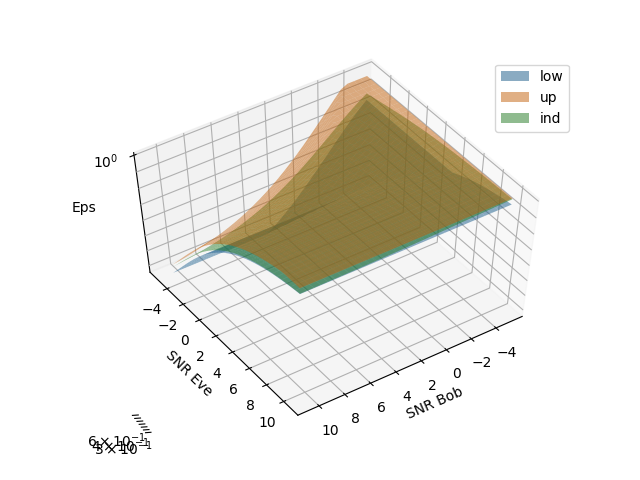

In [6]:
plot_bounds_3d()

In [27]:
def plot_bounds():
    snr_db = np.arange(-5, 11, .5)
    snr_lin = 10**(snr_db/10)
    #snr_lin_eve = 10**(snr_db/10)
    fig, ax = plt.subplots()
    ax.set_xlabel("SNR [dB]")
    ax.set_ylabel("Outage Probability")
    def update_plot(lam_x, lam_y, r_s, r_c):
        ax.clear()
        ax.set_ylim([-.05, 1.05])
        e_a = eps_a(r_s, r_c, lam_x=lam_x, snr_bob=snr_lin)
        e_b = eps_b(r_s, r_c, lam_y=lam_y, snr_eve=snr_lin)
        for bound in ['low', 'up', 'ind']:
            e_joint = eps_joint(r_s, r_c, lam_x=lam_x, lam_y=lam_y, 
                                snr_bob=snr_lin, snr_eve=snr_lin, 
                                copula=bound)
            eps = e_a + e_b - e_joint
            ax.plot(snr_db, eps, label=bound)
        ax.legend()
    interact(update_plot, lam_x=(.5, 2, .1), lam_y=(.5, 2, .1), r_s=(.01, 2, .05), r_c=(.01, 2, .05))

<IPython.core.display.Javascript object>


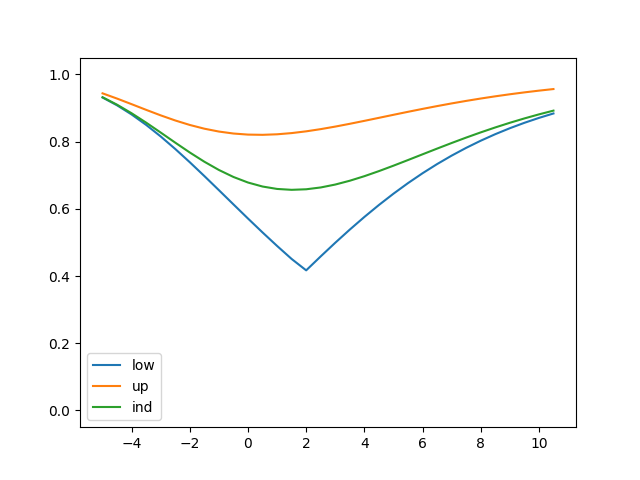

interactive(children=(FloatSlider(value=1.2000000000000002, description='lam_x', max=2.0, min=0.5), FloatSlide…

In [28]:
plot_bounds()